In [17]:
import tools
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score, make_scorer, roc_auc_score
from confusion_matrix.confusion_matrix import plot_confusion_matrix_from_data

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.random_projection import SparseRandomProjection

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [18]:
from importlib import reload
reload(tools)

path_train = '../data/train/'
path_test = '../data/test/'

X_train_origin, y_train = tools.getDataTransformed(path_train + 'database.csv', path_train)
X_test_origin, y_test = tools.getDataTransformed(path_test + 'database.csv', path_test)

In [19]:
dimention_reduction = [None, PCA, TruncatedSVD, LocallyLinearEmbedding, SparseRandomProjection] # LinearDiscriminantAnalysis,
techniques = [RandomForestClassifier(), SVC(), AdaBoostClassifier(), XGBClassifier(use_label_encoder=False, eval_metric='logloss')]
grid_params =[
    {
        'n_estimators': np.arange(10, 100, 10),
        'criterion': ['gini', 'entropy']
    },
    {
        'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree' : np.arange(2,5)
    },
    {
        'n_estimators' : np.arange(10, 100, 10)
    },
    {
        'booster' : ['gbtree', 'gblinear', 'dart'],
        'eta' : np.arange(0.1,0.9,0.2)
    }
]

data_size = range(50,501,200)

In [20]:
# focntions utiles pour trouver le meilleur algo :
def accuracy_scorrer(estimator, X_test, y_test):
    return estimator.score(X_test, y_test)

def recall_scorrer(estimator, X_test, y_true):
    y_pred = estimator.predict(X_test)
    return recall_score(y_true, y_pred, average=None)[0] # recall sur les non normaux (0)

def precision_scorrer(estimator, X_test, y_true):
    y_pred = estimator.predict(X_test)
    return precision_score(y_true, y_pred, average=None)[1] # precision sur les normaux (1)

def precision_and_recall_scorer(estimator, X_test, y_true):
    y_pred = estimator.predict(X_test)
    return precision_score(y_true, y_pred, average=None)[1] + recall_score(y_true, y_pred, average=None)[0]

auc_scorrer = make_scorer(roc_auc_score)

In [21]:
"""technique = RandomForestClassifier()
red = None
print(grid_params[0])
grid = GridSearchCV(estimator=technique, param_grid=grid_params[0])
grid.fit(X_train_origin, y_train)
print(grid.best_estimator_)
model = MachineLearningTechnique(grid.best_estimator_, red)
model.displayMetrics(X_test_origin, y_test)"""

'technique = RandomForestClassifier()\nred = None\nprint(grid_params[0])\ngrid = GridSearchCV(estimator=technique, param_grid=grid_params[0])\ngrid.fit(X_train_origin, y_train)\nprint(grid.best_estimator_)\nmodel = MachineLearningTechnique(grid.best_estimator_, red)\nmodel.displayMetrics(X_test_origin, y_test)'

In [22]:
best_model = None
best_score = -1

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
# regarder du coté des pipeline (voir pour la réduction de dimension)
# https://stackoverflow.com/questions/38555650/try-multiple-estimator-in-one-grid-search

for reduction in dimention_reduction:
    print(reduction)    
    if reduction is None:
        X_train = X_train_origin.copy()
        X_test = X_test_origin.copy()
        for i in range(len(techniques)):
            print(techniques[i])
            grid = GridSearchCV(estimator=techniques[i], param_grid=grid_params[i], scoring=precision_and_recall_scorer) # scorring=precision_and_recall_scorer
            grid_result = grid.fit(X_train, y_train)
            #results = grid_result.cv_results_
            model = tools.MachineLearningTechnique(grid_result.best_estimator_, None)          
            score = auc_scorrer(model.model, X_test, y_test)#model.score(X_test_origin, y_test)
            if score > best_score:
                best_model = model
                best_score = score
        continue
    for size in data_size:
        print(size)
        X_train = X_train_origin.copy()
        X_test = X_test_origin.copy()
        red = reduction(n_components=size)
        try:
            X_train = red.fit_transform(X_train, y_train)
        except Exception as e:
            print(e)
            print(reduction)
            print('fin')
            continue
        X_test = red.transform(X_test)
        for i in range(len(techniques)):
            print(techniques[i])
            grid = GridSearchCV(estimator=techniques[i], param_grid=grid_params[i], scoring=precision_and_recall_scorer) # scorring=precision_and_recall_scorer
            grid_result = grid.fit(X_train, y_train)
            #results = grid_result.cv_results_
            model = tools.MachineLearningTechnique(grid_result.best_estimator_, red)          
            score = precision_and_recall_scorer(model.model, X_test, y_test) #model.score(X_test, y_test)
            if score > best_score:
                best_model = model
                best_score = score

best_model.displayMetrics(X_test_origin, y_test)
best_model.save('../')

None
RandomForestClassifier()
SVC()
AdaBoostClassifier()
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              eval_metric='logloss', gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None)
<class 'sklearn.decomposition._pca.PCA'>
50
RandomForestClassifier()
SVC()
AdaBoostClassifier()
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
          

C:\Users\jleva\anaconda3\envs\GCMS\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jleva\anaconda3\envs\GCMS\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jleva\anaconda3\envs\GCMS\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jleva\anaconda3\envs\GCMS\lib\site-packages\sklearn\met

450
RandomForestClassifier()
SVC()
AdaBoostClassifier()
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              eval_metric='logloss', gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None)


C:\Users\jleva\anaconda3\envs\GCMS\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best reduction PCA(n_components=250)
Best size :  250


AttributeError: 'MachineLearningTechnique' object has no attribute 'var_score'

PCA(n_components=250)
Best reduction PCA(n_components=250)
Best size :  250
Best score :  0.7737226277372263
Model :  RandomForestClassifier(n_estimators=50)
              precision    recall  f1-score   support

           0   0.736111  0.815385  0.773723        65
           1   0.815385  0.736111  0.773723        72

    accuracy                       0.773723       137
   macro avg   0.775748  0.775748  0.773723       137
weighted avg   0.777773  0.773723  0.773723       137



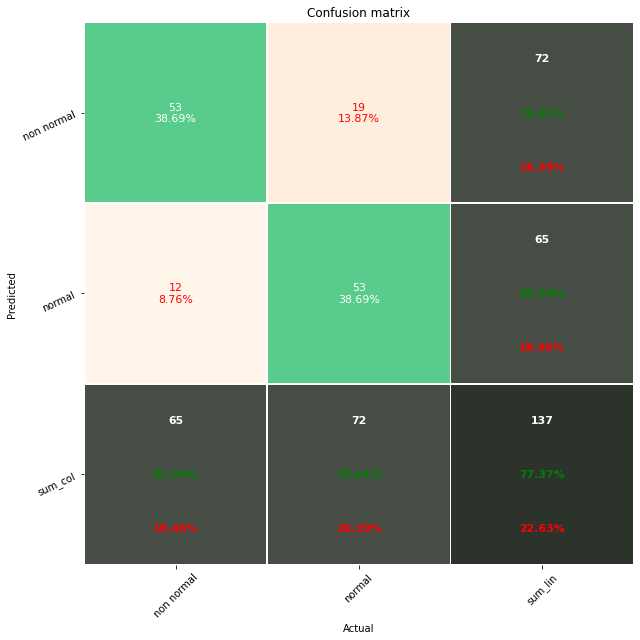

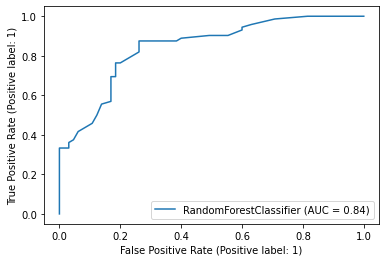

In [23]:
print(best_model.reduction)
reload(tools)
best_model2 = tools.MachineLearningTechnique(best_model.model, best_model.reduction)
best_model2.displayMetrics(X_test_origin, y_test)
best_model2.save('../')

Comparaison avec un Humain (Test non complet pour le moment)
bertrandp-20190201 : 3 + 4 -> 4<br>
settouchei-20190424 : 2 + 3 -> 2<br>
mangonim-20190717 : 0 -> 0<br>
syh-20190912 : 2 -> 2<br>
mastourab-20190219 : 1 (+2 ?) -> 1;4;2<br>
chesinara-20191009 : 3 -> 3<br>
husica-20191108 : 1 + 3 + 4 -> 1<br>
bruyelleCn-20191017 : 3 -> 3<br>
dimolad-20190909 : 2 -> 2<br>
botafemmin-20190225 : 1 -> 1<br>
colakeram-20190923 : 0 ? (sinon 2) -> 0<br>
heriquem-20190329 : 4 ? (cinnamate) -> 5<br>
durmc-20190724 : 0 ? -> 4<br>
piechockil-20190910 : 1 + 4 -> 3;4<br>
heriquem-20190329 : 3 -> 5<br>
genouxm-20190401 : 2 + 3 -> 2<br>

              precision    recall  f1-score   support

           0   0.928571  1.000000  0.962963        13
           1   1.000000  0.666667  0.800000         3

    accuracy                       0.937500        16
   macro avg   0.964286  0.833333  0.881481        16
weighted avg   0.941964  0.937500  0.932407        16



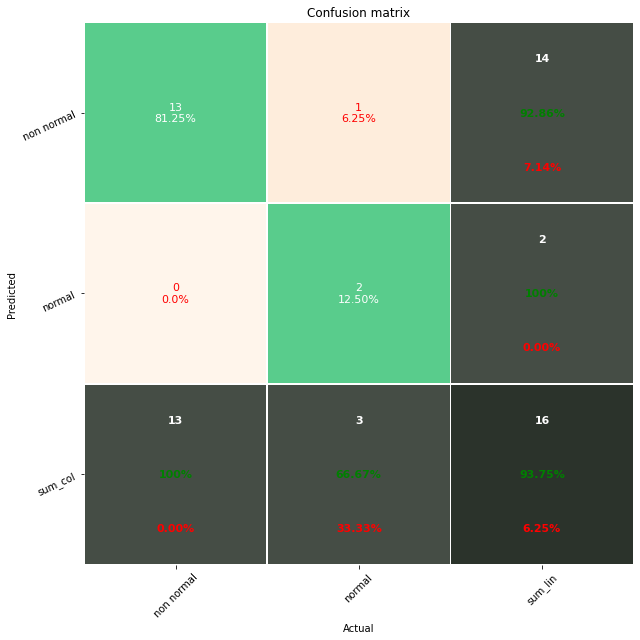

In [38]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
y_test = [0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0]
y_predict = [0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0]
#y_test = np.array([[0,0,0,0,1,0],[0,0,0,1,0,0],[1,0,0,0,0,0],[0,0,1,0,0,0],[0,1,1,0,1,0],[0,0,0,1,0,0],[0,1,0,0,0,0],[0,0,0,1,0,0],[0,0,1,0,0,0],[0,1,0,0,0,0],[1,0,0,0,0,0],[0,0,0,0,0,1],[0,0,0,0,1,0],[0,0,0,1,1,0],[0,0,0,0,0,1],[0,0,1,0,0,0]])
#y_predict = np.array([[0,0,0,1,1,0],[0,0,1,1,0,0],[1,0,0,0,0,0],[0,0,1,0,0,0],[0,1,1,0,0,0],[0,0,0,1,0,0],[0,1,0,1,1,0],[0,0,0,1,0,0],[0,0,1,0,0,0],[0,1,0,0,0,0],[1,0,0,0,0,0],[0,0,0,0,1,0],[1,0,0,0,0,0],[0,1,0,0,1,0],[0,0,0,1,0,0],[0,0,1,1,0,0]])

#print(precision_score(y_test, y_predict, average=None)[1])
#print(recall_score(y_test, y_predict, average=None)[0])

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_predict
)
print(sk_report)
#matrix = multilabel_confusion_matrix(y_test, y_predict)#,columns=['non normal','normal'])
#print(matrix)
#disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
#disp.plot()
plot_confusion_matrix_from_data(y_test, y_predict, columns=['non normal','normal'])